## SF crime data analysis and modeling (DD: 10/12/2020 过期不侯哈)

### In this notebook, you can learn how to use Spark SQL for big data analysis on SF crime data. (https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry). 
The first part of Homework is OLAP for scrime data analysis (80 credits).  
The second part is unsupervised learning for spatial data analysis (20 credits). 选做  
The option part is the time series data analysis (50 credits).  选座
**Note**: you can download the small data (one month e.g. 2018-10) for debug, then download the data from 2013 to 2018 for testing and analysising. 

### How to submit the report for grading ? 
1. Publish your notebook and send your notebook link to mike@laioffer.com. 
2. Your report have to contain your data analysis insights.  
3. write a ppt to present your work （选作）

### Bonus 
1. choose different city (加10分)
2. choose different analysis question （加10分）
3. include other data together like house price, weather, news (加20分)

### Deadline 
Two weeks from the homework release date

### cluster 创建
创建cluster 的时候选择python 3  

### 画图
1. 使用Databricks 自带的画图就好了，不要求使用其他的工具
2. 如果使用其他的包，请使用display 

### Time series 
不讲，个人随意

### others
个人需要发挥主观能动性

In [0]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings

import os
os.environ["PYSPARK_PYTHON"] = "python3"


In [0]:
# 从SF gov 官网读取下载数据
# 不要反复执行，大家执行一次就好了啊
# 第二次记得comment 掉
#import urllib.request
#urllib.request.urlretrieve("https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?#accessType=DOWNLOAD", "/tmp/myxxxx.csv")
#dbutils.fs.mv("file:/tmp/myxxxx.csv", "dbfs:/laioffer/spark_hw1/data/sf_03_18.csv")
#display(dbutils.fs.ls("dbfs:/laioffer/spark_hw1/data/"))
## 或者自己下载
# https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD


In [0]:
data_path = "dbfs:/laioffer/spark_hw1/data/sf_03_18.csv"
# use this file name later

### Solove  big data issues via Spark
approach 1: use RDD (not recommend)  
approach 2: use Dataframe, register the RDD to a dataframe (recommend for DE)  
approach 3: use SQL (recomend for data analysis or DS， 基础比较差的同学)  
***note***: you only need to choose one of approaches as introduced above

In [0]:

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df_opt1 = spark.read.format("csv").option("header", "true").load(data_path)
display(df_opt1)
df_opt1.createOrReplaceTempView("sf_crime")

## helper function to transform the date, choose your way to do it. 
## 老师我真的是操心了。。。 
# refer: https://jaceklaskowski.gitbooks.io/mastering-spark-sql/spark-sql-functions-datetime.html
# 方法1 使用系统自带udf
# from pyspark.sql.functions import to_date, to_timestamp, hour
# df_opt1 = df_opt1.withColumn('Date', to_date(df_opt1.OccurredOn, "MM/dd/yy"))
# df_opt1 = df_opt1.withColumn('Time', to_timestamp(df_opt1.OccurredOn, "MM/dd/yy HH:mm"))
# df_opt1 = df_opt1.withColumn('Hour', hour(df_opt1['Time']))
# df_opt1 = df_opt1.withColumn("DayOfWeek", date_format(df_opt1.Date, "EEEE"))

## 方法2 手工写udf 
#from pyspark.sql.functions import col, udf
#from pyspark.sql.functions import expr
#from pyspark.sql.functions import from_unixtime

#date_func =  udf (lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())
#month_func = udf (lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%Y/%m'), StringType())

#df = df_opt1.withColumn('month_year', month_func(col('Date')))\
#           .withColumn('Date_time', date_func(col('Date')))

## 方法3 手工在sql 里面
#select Date，substring(Date，7) as Year， substring(Date，1，2) as Month from sf_crime


## 方法4: 使用系统自带
from pyspark.sql.functions import *
df_update = df_opt1.withColumn("Date", to_date(col("Date"), "MM/dd/yyyy")) ##change datetype from string to date
df_update.createOrReplaceTempView("sf_crime")
crimeYearMonth = spark.sql("SELECT Year(Date) AS Year, Month(Date) AS Month, FROM sf_crime")

PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,location,SF Find Neighborhoods 2 2,Current Police Districts 2 2,Current Supervisor Districts 2 2,Analysis Neighborhoods 2 2,DELETE - Fire Prevention Districts 2 2,DELETE - Police Districts 2 2,DELETE - Supervisor Districts 2 2,DELETE - Zip Codes 2 2,DELETE - Neighborhoods 2 2,DELETE - 2017 Fix It Zones 2 2,Civic Center Harm Reduction Project Boundary 2 2,Fix It Zones as of 2017-11-06 2 2,DELETE - HSOC Zones 2 2,Fix It Zones as of 2018-02-07 2 2,"CBD, BID and GBD Boundaries as of 2017 2 2","Areas of Vulnerability, 2016 2 2",Central Market/Tenderloin Boundary 2 2,Central Market/Tenderloin Boundary Polygon - Updated 2 2,HSOC Zones as of 2018-06-05 2 2,OWED Public Spaces 2 2,Neighborhoods 2
11087941463010,110879414,63010,WARRANTS,WARRANT ARREST,Friday,07/01/2011,08:00,NORTHERN,"ARREST, BOOKED",3400 Block of PIERCE ST,-122.439757857075,37.8021507619169,POINT (-122.43975785707501 37.8021507619169),17,4,6,13,13,9,1,57,17,null,null,null,null,null,null,1,null,null,null,null,17
5117770316010,051177703,16010,DRUG/NARCOTIC,POSSESSION OF MARIJUANA,Tuesday,10/18/2005,14:30,TENDERLOIN,"ARREST, BOOKED",0 Block of UNITEDNATIONS PZ,-122.414317857881,37.7799444052046,POINT (-122.414317857881 37.7799444052046),21,5,10,36,7,10,9,28852,36,3,1,3,1,3,6,2,1,1,1,39,21
5011209707055,050112097,07055,VEHICLE THEFT,RECOVERED VEHICLE - STOLEN OUTSIDE SF,Saturday,01/29/2005,13:45,BAYVIEW,NONE,1500 Block of KIRKWOOD AV,-122.388798895151,37.7375755833256,POINT (-122.38879889515101 37.7375755833256),86,2,9,1,10,3,8,58,1,null,null,null,null,null,null,2,null,null,null,null,86
11044468164020,110444681,64020,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Thursday,06/02/2011,02:52,CENTRAL,PSYCHOPATHIC CASE,900 Block of COLUMBUS AV,-122.414354301151,37.8031089840376,POINT (-122.41435430115101 37.8031089840376),107,6,3,32,3,1,10,308,32,null,null,null,null,null,null,1,null,null,null,null,107
3038311107024,030383111,07024,VEHICLE THEFT,STOLEN TRAILER,Saturday,02/01/2003,08:00,BAYVIEW,NONE,1500 Block of BAY SHORE BL,-122.401096851568,37.7245556697717,POINT (-122.401096851568 37.7245556697717),86,2,9,1,10,3,8,58,1,null,null,null,null,null,null,2,null,null,null,null,86
6018621406243,060186214,06243,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,Sunday,02/12/2006,17:00,CENTRAL,NONE,400 Block of DAVIS CT,-122.398187664281,37.7967148853927,POINT (-122.39818766428101 37.7967148853927),77,6,3,8,3,1,10,28860,6,null,null,null,null,null,null,1,null,null,null,null,77
9606640606374,096066406,06374,LARCENY/THEFT,GRAND THEFT OF PROPERTY,Thursday,08/06/2009,22:00,RICHMOND,NONE,2000 Block of BAKER ST,-122.444143357971,37.7899090887789,POINT (-122.44414335797102 37.7899090887789),102,8,6,30,13,6,1,29490,27,null,null,null,null,null,null,1,null,null,null,null,102
10037601606304,100376016,06304,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Friday,04/23/2010,16:30,MISSION,NONE,2600 Block of MISSION ST,-122.41860030589,37.7546255872838,POINT (-122.41860030589001 37.7546255872838),53,3,2,20,2,4,7,28859,19,null,null,null,3,null,null,2,null,null,3,null,53
5118607706244,051186077,06244,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Thursday,10/20/2005,11:00,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403404791479,37.775420706711,POINT (-122.40340479147902 37.775420706711),32,1,10,34,14,2,9,28853,34,null,null,null,null,null,null,2,null,null,null,null,32
12038512205053,120385122,05053,BURGLARY,"BURGLARY OF STORE, UNLAWFUL ENTRY",Thursday,05/03/2012,10:00,SOUTHERN,NONE,600 Block of 2ND ST,-122.39123835272,37.7812532736369,POINT (-122.39123835272001 37.7812532736369),31,1,10,8,6,2,9,28856,6,null,null,null,null,null,null,1,null,null,null,null,31


#### Q1 question (OLAP): 
#####Write a Spark program that counts the number of crimes for different category.

Below are some example codes to demonstrate the way to use Spark RDD, DF, and SQL to work with big data. You can follow this example to finish other questions.

In [0]:
q1_result = df_opt1.groupBy('category').count().orderBy('count', ascending=False)
display(q1_result)

category,count
LARCENY/THEFT,477975
OTHER OFFENSES,303027
NON-CRIMINAL,236937
ASSAULT,191384
VEHICLE THEFT,126228
DRUG/NARCOTIC,117875
VANDALISM,114718
WARRANTS,99821
BURGLARY,91067
SUSPICIOUS OCC,79740


In [0]:
#Spark SQL based
crimeCategory = spark.sql("SELECT  category, COUNT(*) AS Count FROM sf_crime GROUP BY category ORDER BY Count DESC")
display(crimeCategory)

category,Count
LARCENY/THEFT,477975
OTHER OFFENSES,303027
NON-CRIMINAL,236937
ASSAULT,191384
VEHICLE THEFT,126228
DRUG/NARCOTIC,117875
VANDALISM,114718
WARRANTS,99821
BURGLARY,91067
SUSPICIOUS OCC,79740


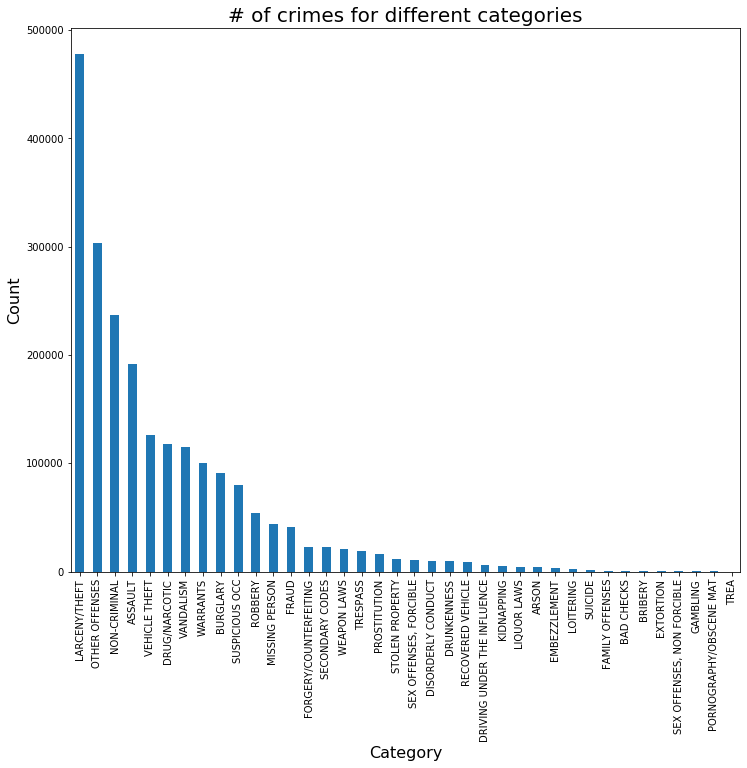

In [0]:
# important hints: 
## first step: spark df or sql to compute the statisitc result 
## second step: export your result to a pandas dataframe. 

crimes_pd_df = crimeCategory.toPandas()

# Spark does not support this function, please refer https://matplotlib.org/ for visuliation. You need to use display to show the figure in the databricks community. 

ax = crimes_pd_df.plot(kind = "bar", x="category", y = "Count", legend = False, figsize = (12,10))
plt.xticks(rotation =90)
plt.xlabel("Category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("# of crimes for different categories", fontsize = 20)
display()

#### Q2 question (OLAP)
Counts the number of crimes for different district, and visualize your results

In [0]:
# df count number of crimes for different district and visualize
crimeDristrict=df_opt1.groupBy('PdDistrict').count().orderBy('count',ascending=False)
display(crimeDistrict)

PdDistrict,count
SOUTHERN,394234
MISSION,293072
NORTHERN,269229
CENTRAL,223962
BAYVIEW,210729
TENDERLOIN,189034
INGLESIDE,186645
TARAVAL,158710
PARK,121070
RICHMOND,114267


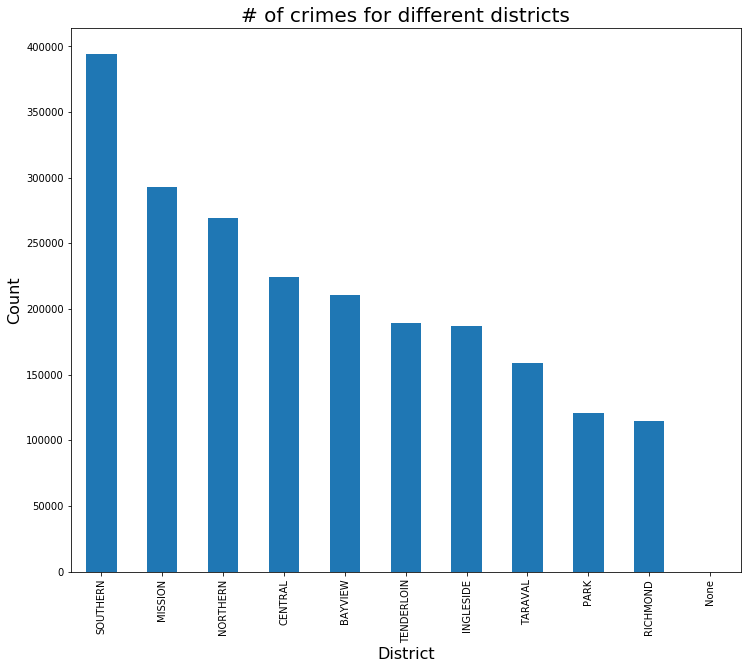

In [0]:
# SQL Count number of crimes for different district and visualize
crimeDistrict=spark.sql('select PdDistrict, count(*) as count from sf_crime group by PdDistrict order by count desc')
crimes_d = crimeDistrict.toPandas()
ax = crimes_d.plot(kind = "bar", x="PdDistrict", y = "count", legend = False, figsize = (12,10))
plt.xticks(rotation =90)
plt.xlabel("District", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("# of crimes for different districts", fontsize = 20)
display()

#### Q3 question (OLAP)
Count the number of crimes each "Sunday" at "SF downtown".   
hint 1: SF downtown is defiend  via the range of spatial location. For example, you can use a rectangle to define the SF downtown, or you can define a cicle with center as well. Thus, you need to write your own UDF function to filter data which are located inside certain spatial range. You can follow the example here: https://changhsinlee.com/pyspark-udf/

hint 2: SF downtown 物理范围可以是 rectangle a < x < b  and c < y < d. thus, San Francisco Latitude and longitude coordinates are: 37.773972, -122.431297. X and Y represents each. So we assume SF downtown spacial range: X (-122.4213,-122.4313), Y(37.7540,37.7740). 也可以是中心一个圈，距离小于多少算做downtown

In [0]:
# SQL
crimeSunday=spark.sql('select count(*) as count from (select DayOfWeek, X, Y from sf_crime where DayOfWeek="Sunday") as CrimeS where X<=-122.4213 and X>=-122.4313 and Y>=37.7540 and Y<=37.7740')
display(crimeSunday)

count
10950


#### Q4 question (OLAP)
Analysis the number of crime in each month of 2015, 2016, 2017, 2018. Then, give your insights for the output results. What is the business impact for your result?

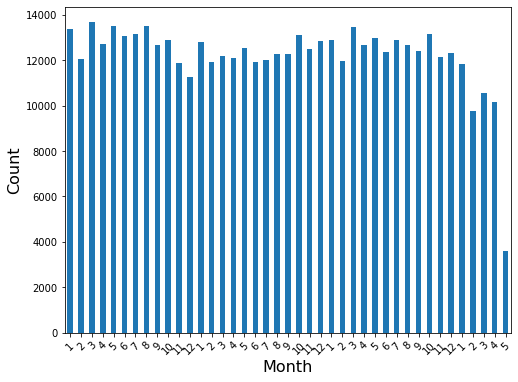

In [0]:
#SQL 
crimeMonth=spark.sql("with cte as(select year(Date) as Year, month(Date) as Month from sf_crime) select Year, Month, count(*) as count from cte where Year between 2015 and 2018 group by Year, Month order by Year, Month ")
crimeM = crimeMonth.toPandas()
ax = crimeM.plot(kind = "bar", x="Month", y = "count", legend = False, figsize = (8,6))
plt.xticks(rotation = 45)
plt.xlabel("Month", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
display()

In [0]:
# DataFrame
from pyspark.sql.types import DateType
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType, IntegerType, array, FloatType
from pyspark.sql.functions import unix_timestamp, from_unixtime
month_func = udf (lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%Y/%m'), StringType())

df_q4 = df_opt1.withColumn('month_year', month_func(col('Date')))

q4_result = df_q4.filter((df_q4.month_year >= "2015/01") & (df_q4.month_year <= "2018/12")).groupBy('month_year').count().orderBy('month_year')
display(q4_result)

month_year,count
2015/01,13370
2015/02,12055
2015/03,13674
2015/04,12705
2015/05,13511
2015/06,13073
2015/07,13158
2015/08,13523
2015/09,12666
2015/10,12889


In 2015-2017, the number of crimes per month is similar. There is noly 5 month of record in 2018. 
In Feburary 2018, the number of crimes drops sharply. 
In the first 5 months of 2018, the number of crimes is lower than befor.
In each year, fewer crimes happen during winter. There is a potential to open more stores and increase market events during winter.

#### Q5 question (OLAP)
Analysis the number of crime w.r.t the hour in certian day like 2015/12/15, 2016/12/15, 2017/12/15. Then, give your travel suggestion to visit SF.

In [0]:
date_func =  udf (lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())
hour_func = udf (lambda x: float(x[:2]), FloatType())

Hour_Date=df_opt1.withColumn('Hour',hour_func(col('Time'))).withColumn('date',date_func(col('Date')))
crimeHour=Hour_Date.filter((Hour_Date.date=='2015-12-15')|(Hour_Date.date=='2016-12-15')|(Hour_Date.date=='2017-12-15')).groupBy('date','Hour').count().orderBy('date','Hour')
display(crimeHour)

Crimes are less from 0am to 8am. Crimes are more likely to happen during noon and night, from 6pm to midnight. I would suggest that travelers pay more attention on safety when going out at night and during noon.

#### Q6 question (OLAP)
(1) Step1: Find out the top-3 danger disrict  
(2) Step2: find out the crime event w.r.t category and time (hour) from the result of step 1  
(3) give your advice to distribute the police based on your analysis results.

In [0]:
# Find out top 3 danger district
top=spark.sql("select PdDistrict, count(*) as count from sf_crime group by 1 order by count desc limit 3")
display(top)

In [0]:
#find out the crime event w.r.t category and time (hour) from the result of step 1
crimeEvt = Hour_Date.filter((Hour_Date.PdDistrict == 'SOUTHERN') | (Hour_Date.PdDistrict == 'MISSION') | (Hour_Date.PdDistrict == 'NORTHERN')).groupBy('category', 'Hour').count().orderBy('category','Hour')
display(crimeEvt)

Top 3 districts with largest crime numbers are Southern, Mission, and Northern.
More police power is needed to deal with theft/larceny.
More police power is needed during night.

#### Q7 question (OLAP)
For different category of crime, find the percentage of resolution. Based on the output, give your hints to adjust the policy.

In [0]:
# percentage of resolution
res_per=spark.sql("with cte as (select Category, Resolution, case when Resolution in ('NONE') then 0 else 1 end as res from sf_crime) select Category, sum(res) as sum_res, count(*) as count, sum(res)*100/count(*) as Percentage from cte group by Category")
display(res_per)

In [0]:
res_per=spark.sql("with cte as (select Category, Resolution, case when Resolution in ('NONE') then 0 else 1 end as res from sf_crime) select Category, sum(res) as sum_res, count(*) as count, sum(res)*100/count(*) as Percentage from cte group by Category order by Percentage")
display(res_per)

### Conclusion. 
Use four sentences to summary your work. Like what you have done, how to do it, what the techinical steps, what is your business impact. 
More details are appreciated. You can think about this a report for your manager. Then, you need to use this experience to prove that you have strong background on big  data analysis.  
Point 1:  what is your story ? and why you do this work ?   
Point 2:  how can you do it ?  keywords: Spark, Spark SQL, Dataframe, Data clean, Data visulization, Data size, clustering, OLAP,   
Point 3:  what do you learn from the data ?  keywords: crime, trend, advising, conclusion, runtime

We are a traveler magazine and we are writing an article about SF. Our potential readers include travelers and local store owners. We want to give them travel guidance as well as information like where is the best place to extend business. So I make an analysis on the crimes in SF to evaluate its safty environment. I use Spark SQL, Dataframe, Data clean, Data visualization to do OLAP.
By analyzing, I found that in SF theft and larceny are the most common crimes, with over 477975 events from 2003. The most dangerous districts are southern(394234 events), mission(293072 events) and northern(269229). Most crimes happen during nights, from 6pm to 0am. There is a drop in number of crimes happen in 2018 compared to years before. In each year from 2015 to 2017, the number of crimes in winter is less campared to other months. In all categories, the 3 that have lowest percentage of resolution (below 10%) are recovered vehicle, vehicle theft, and larceny/theft.
Based on the analysis, we would recommend travelers to come during holiday seasons and pay attention on safty when going out during night. We also suggest that people avoid the three district with most criminal events. We would recommend store owners to open more business during holiday season and also avoid the three most dangerous districts.

### Optional part: Clustering
You can apply Spark ML custering algorithm to cluster the spatial data, then visualize the clustering results. Do not do this until you understand Spark ML, we would like to cover this in the DS track.

In [0]:
#refer: https://spark.apache.org/docs/latest/ml-clustering.html

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
# Loads data.
df_8 = df_opt1.select(['IncidntNum','X','Y'])
#Prepare features
FEATURES_COL = ['X', 'Y']
for col in df_8.columns:
    if col in FEATURES_COL:
        df_8 = df_8.withColumn(col,df_8[col].cast('float'))
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df_8).select('IncidntNum', 'features')

#

### Optional part: Time series analysis
This part is not based on Spark, and only based on Pandas Time Series package.   
Note: I am not familiar with time series model, please refer the ARIMA model introduced by other teacher.   
process:  
1.visualize time series  
2.plot ACF and find optimal parameter  
3.Train ARIMA  
4.Prediction 

Refer:   
https://zhuanlan.zhihu.com/p/35282988  
https://zhuanlan.zhihu.com/p/35128342  
https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html  
https://www.howtoing.com/a-guide-to-time-series-forecasting-with-arima-in-python-3  
https://www.joinquant.com/post/9576?tag=algorithm  
https://blog.csdn.net/u012052268/article/details/79452244

#### How to implement a inner join/ left join/right join via Python? 选做哈

For example 

Array 1: [[1, "mike", "f"], [2, "jason", "f"], [3, "robin", "m"], ...] 

Array 2: [[1, "95051", "CS"], [2, "95001", "DS"], [6, "robin", "DE"], ...]